## MAD normalization on all features

#### Inspiration 

https://pypi.org/project/loess/

https://github.com/pharmbio/plaid/blob/main/simulations/PLAID-bioseminar-plots-2021.ipynb

https://github.com/pharmbio/plaid/blob/main/simulations/libraries/normalization.py 

In [1]:
import pandas as pd 
import numpy as np

import math, os

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
#from loess.loess_2d import loess_2d

pd.set_option('display.max_columns', 50)
#matplotlib inline
os.getcwd()


'/Users/chririn/Documents/Code/2D_analysis'

In [2]:
def front(self, n):
    return self.iloc[:, :n]

def back(self, n):
    return self.iloc[:, -n:]

pd.DataFrame.front = front
pd.DataFrame.back = back

# consider making this into a utility
# https://stackoverflow.com/questions/30608310/is-there-a-pandas-function-to-display-the-first-last-n-columns-as-in-head 

In [3]:
BaseDir = "results"
OutputDir = 'results'

if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

## Load data 

In [4]:
df = pd.read_csv('{}/colo44_cleaned_data.csv'.format(BaseDir), sep=';' , index_col=0)
df.back(27).head(1)

,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,well_id,site,ImageID,barcode,plate_well,batch_id,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,well_vol,well_vol_unit,pert_type,cmpd_conc,cmpd_conc_unit,batchid,cbkid,libid,libtxt,smiles,inchi,inkey,conc,compound,Count_nuclei
0,0.426303,B02,1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02_1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02,PHB000015,dmso,10.0,mM,7.5,nL,30,uL,poscon,2.5,uM,PHB000015,[tetr],[tetr],pharmb_io,NaN,NaN,NaN,2.5,[tetr],74.0


In [5]:
df.front(27).head(1)

,ObjectNumber_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,AreaShape_Eccentricity_nuclei,AreaShape_EquivalentDiameter_nuclei,AreaShape_EulerNumber_nuclei,AreaShape_Extent_nuclei,AreaShape_FormFactor_nuclei,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei,AreaShape_Zernike_0_0_nuclei
0,53.5,1860.0,2597.0,1062.5,806.5,1017.5,764.5,1037.132364,785.629139,1.201793,1933.5,0.696281,48.663968,1.0,0.725935,0.832093,57.710049,58.32857,20.383371,7.753648,7.0,42.026644,42.200039,-19.831706,170.145707,0.970882,0.690988


In [57]:
# Some information about the experiment
listOfPlates = df['barcode'].unique()
NrOfPlates = len(listOfPlates)
print('Number of plates: %s' %(NrOfPlates))
Wells = sorted(list(set(df['well_id'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)
ListOfFeatures = df.columns[:-26].to_list()## Select all the features.
NrOfFeatures = len(ListOfFeatures)
print('Number of features: %s' %(NrOfFeatures))
ListOfMetaData = df.columns[-26:-1].to_list()## Select all the features.
print(ListOfMetaData)

Number of plates: 4
Number of wells: 308
B C D E F G H I J K L M N O
02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23
Number of features: 2182
['well_id', 'site', 'ImageID', 'barcode', 'plate_well', 'batch_id', 'solvent', 'stock_conc', 'stock_conc_unit', 'cmpd_vol', 'cmpd_vol_unit', 'well_vol', 'well_vol_unit', 'pert_type', 'cmpd_conc', 'cmpd_conc_unit', 'batchid', 'cbkid', 'libid', 'libtxt', 'smiles', 'inchi', 'inkey', 'conc', 'compound']


#### Calculate weigthed well means

In [71]:
ListOfMetaData.remove('ImageID')
ListOfMetaData.remove('site')


#### Normal well means

In [72]:
dfPerWell = df[ListOfFeatures + ['plate_well']].groupby(['plate_well']).mean()
dfPerWell = pd.merge(left=dfPerWell, right=df[ListOfMetaData], how = 'left', on='plate_well')
dfPerWell = dfPerWell.drop_duplicates()

#### Well aggregates

The code below should work, but is unfortunatly not on a plate basis. 

In [18]:
# dfwell_average = df[ListOfFeatures + ['plate_well']].groupby(['plate_well']).mean()

# dfDMSO = df[df["compound"] == "[dmso]"]
# dfDMSOwell_average = dfDMSO[ListOfFeatures + ['plate_well']].groupby(['plate_well']).mean()

# dfDMSO_MADs = ((dfDMSOwell_average[ListOfFeatures] - dfDMSOwell_average[ListOfFeatures].median()).abs().median())
# dfDMSO_MADs = dfDMSOwell_average[ListOfFeatures].median()

# dfZscores = (dfwell_average[ListOfFeatures] - dfDMSO_Medians[ListOfFeatures]) / dfDMSO_MADs[ListOfFeatures]


In [133]:
dfNormalized = dfPerWell.copy()

for OnePlate in listOfPlates:
    PerPlate = dfPerWell[dfPerWell['barcode'] == OnePlate]
    PerPlateDMSO = dfPerWell[dfPerWell["compound"] == "[dmso]"]
    
    dfDMSO_MADs = ((PerPlateDMSO[ListOfFeatures] - PerPlateDMSO[ListOfFeatures].median()).abs().median())
    dfDMSO_Median = PerPlateDMSO[ListOfFeatures].median()

    dfNorm = PerPlate.copy()
    dfNorm[ListOfFeatures] = (PerPlate[ListOfFeatures] - dfDMSO_Median[ListOfFeatures]) / dfDMSO_MADs[ListOfFeatures]
    dfNormalized[dfPerWell['barcode'] == OnePlate] = dfNorm

In [ ]:
dfNormalized.to_csv("{}/colo44_MAD_normalized.csv".format(OutputDir), sep=";")

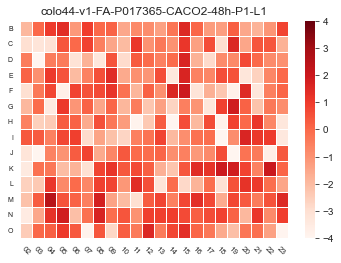

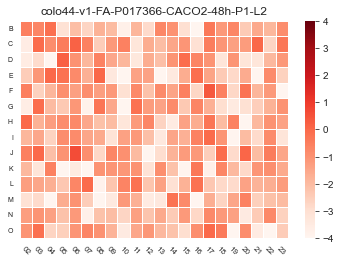

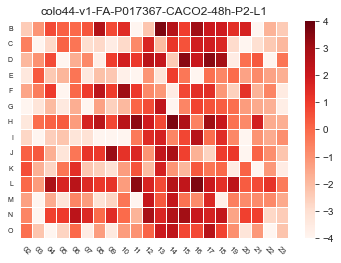

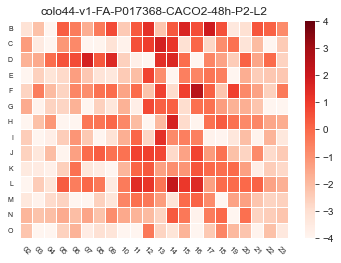

In [129]:
feature = 'ObjectNumber_cells'
cmap = 'Reds'



for OnePlate in listOfPlates:
    PerPlate = dfPerWell[dfPerWell['barcode'] == OnePlate]
    PerPlateDMSO = dfPerWell[dfPerWell["compound"] == "[dmso]"]
    
    dfDMSO_MADs = ((PerPlateDMSO[ListOfFeatures] - PerPlateDMSO[ListOfFeatures].median()).abs().median())
    dfDMSO_Median = PerPlateDMSO[ListOfFeatures].median()

    dfNorm = PerPlate.copy()
    dfNorm[ListOfFeatures] = (PerPlate[ListOfFeatures] - dfDMSO_Median[ListOfFeatures]) / dfDMSO_MADs[ListOfFeatures]

    # Set up the heatmap boundaries
    vmed = math.ceil(dfNorm[feature].quantile(0.5)*1000)/1000
    vmin = 0 

    groupedby_norm = dfNorm[[feature,'plate_well','well_id']].copy()
    groupedby_norm["columns"] = groupedby_norm['plate_well'].str[-3:-2]
    groupedby_norm["columns"] = [ ord(x) - 64 for x in groupedby_norm["columns"]]
    groupedby_norm["rows"] = groupedby_norm['plate_well'].str[-2:].str.lstrip('0')
    groupedby_norm["rows"] = groupedby_norm["rows"].astype(int)
    groupedby_norm.index = groupedby_norm['well_id']
   
   # Remove non-exisiting wells
    for W in Wells:
      if W not in groupedby_norm.index:
            groupedby_norm.loc[W] = 0
    groupedby_norm.sort_index(inplace=True) 

    # Prepare data for plotting
    groupedbyvalues = groupedby_norm[feature].values.copy()
    groupedbyvalues = groupedbyvalues.reshape(NrOfRows,int(NrOfColumns))
    groupedby_norm = pd.DataFrame(groupedbyvalues)
    groupedby_norm.columns = Columns
    groupedby_norm.index = Rows

    # Subplots 
    plt.figure()
    sns.heatmap(groupedby_norm, cmap=cmap, # all data
                                    #vmin = vmed * -4.5,
                                    #vmax = vmed * 2.5,
                                    vmin = -4,
                                    vmax = 4,
                                    square = False,
                                    linewidths = .5,
                                    xticklabels = 1, yticklabels = groupedby_norm.index,
                                    )

    plt.yticks(fontsize=7,rotation=0)
    plt.xticks(fontsize=8,rotation= -45) 

    plt.title(OnePlate, fontsize = 12, loc = 'center')